In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import string
import re
import random
import missingno as msno
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import os
from tqdm.notebook import tqdm
import tensorflow_hub as hub
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
%matplotlib inline

# Reading DataSets

In [2]:
train1 = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv') 

In [3]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']]
])

# Class Imbalance Problem

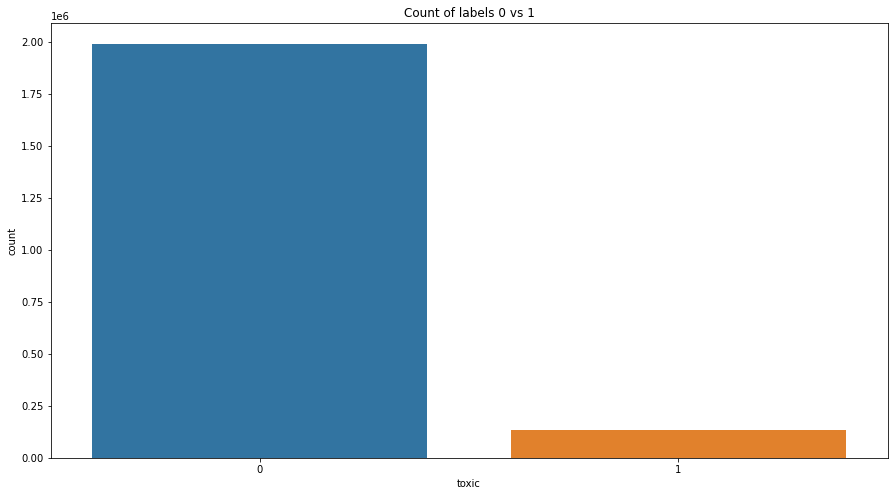

In [4]:
plt.figure(figsize = (15, 8))
plt.title("Count of labels 0 vs 1")
plt.xlabel("Toxic")
plt.ylabel("Count")
sns.countplot(x = "toxic", data = train)

In [5]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1')
#     train2[['comment_text', 'toxic']].query('toxic==0').sample(n=30000, random_state=0)
]).sample(100000, random_state = 1)
train = pd.concat([
    train,
    valid[["comment_text", "toxic"]]
])

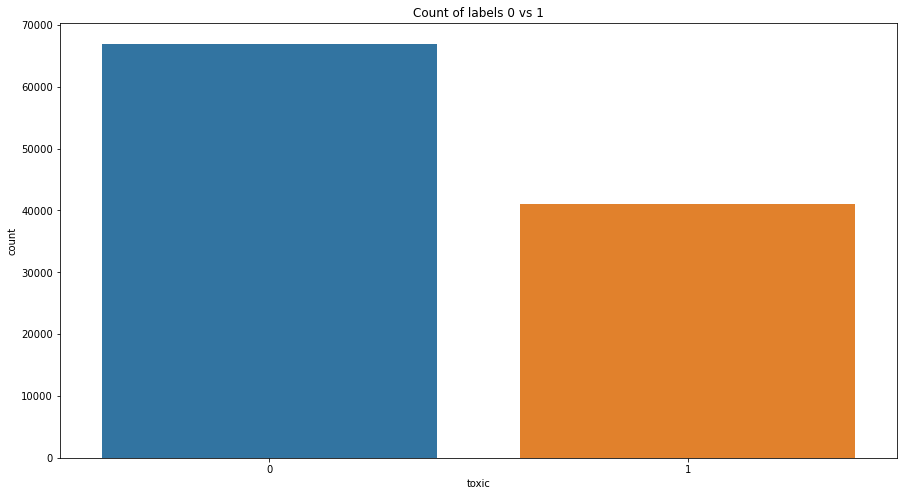

In [6]:
plt.figure(figsize = (15, 8))
plt.title("Count of labels 0 vs 1")
plt.xlabel("Toxic")
plt.ylabel("Count")
sns.countplot(x = "toxic", data = train)

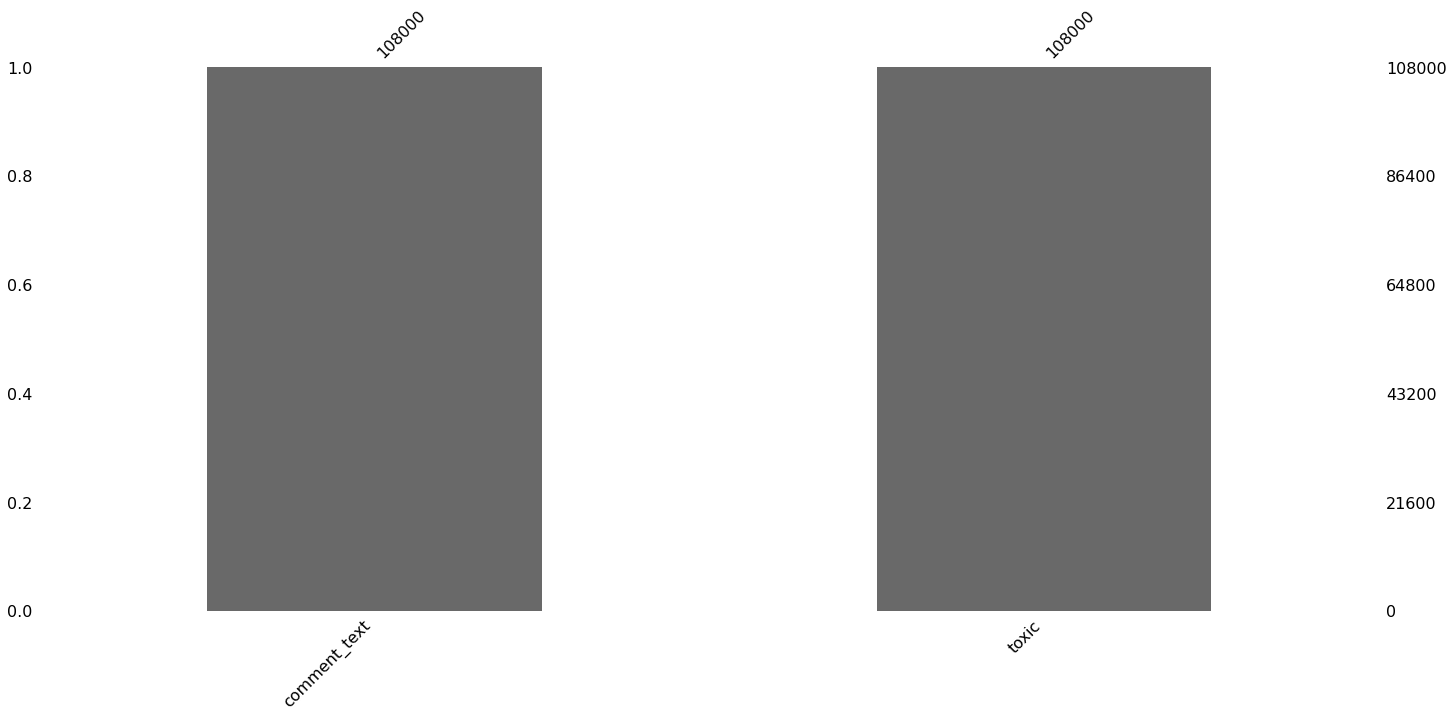

In [7]:
plt.figure(figsize = (12, 8))
msno.bar(train)

In [8]:
stopwords = set(STOPWORDS)

def  word_cloud(data, title =None):
    data = data.apply(lambda x : x.lower())
    cloud = WordCloud(
    background_color = "black",
    stopwords = stopwords,
    max_words = 200,
    max_font_size = 40,
    scale = 3).generate(str(data))
    
    fig = plt.figure(figsize= (15, 15))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)

    plt.imshow(cloud)
    plt.show()

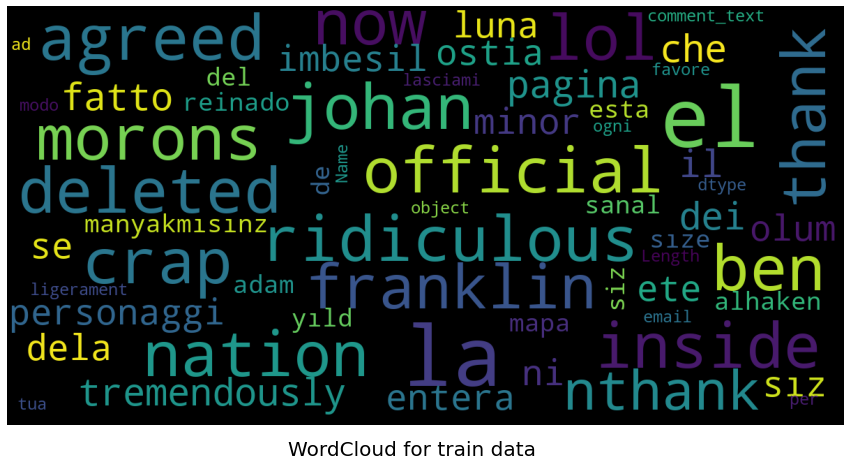

In [9]:
word_cloud(train["comment_text"], "WordCloud for train data")

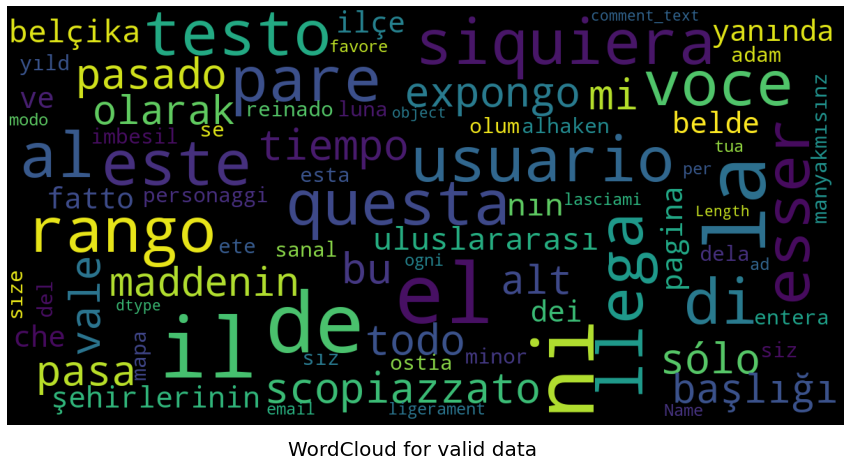

In [10]:
word_cloud(valid["comment_text"].apply(str), "WordCloud for valid data")

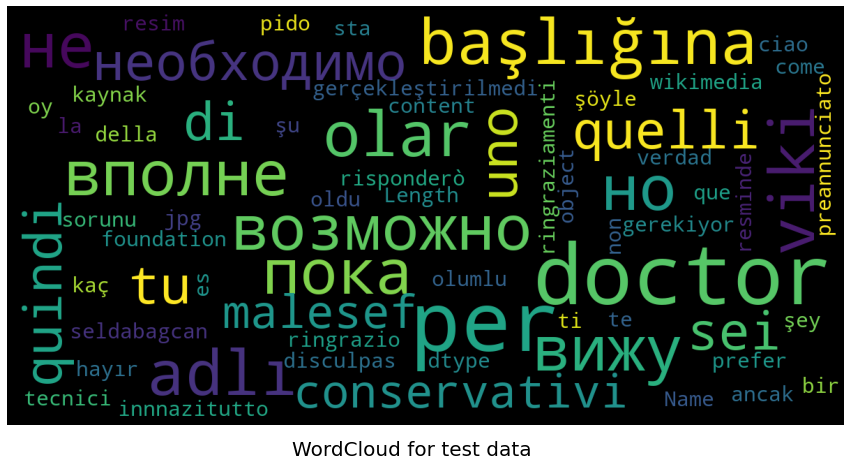

In [11]:
word_cloud(test["content"], "WordCloud for test data")

Text(0, 0.5, 'Probability of occurance')

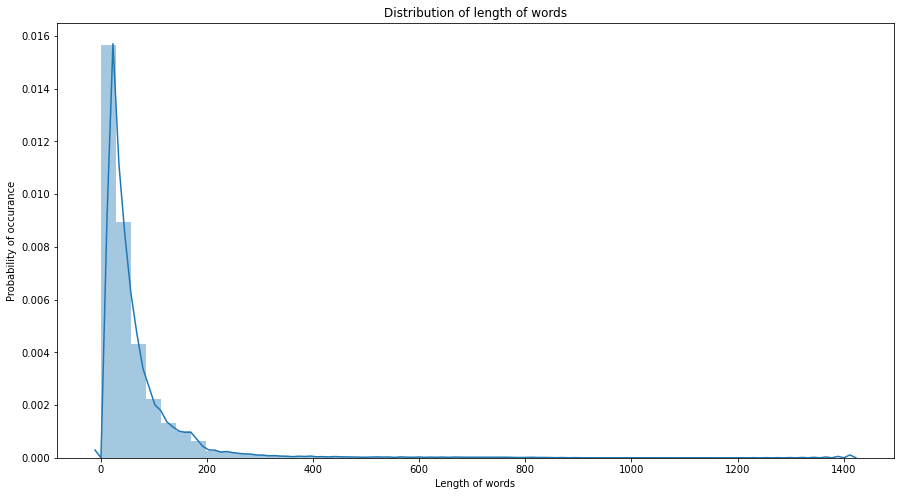

In [12]:
plt.figure(figsize = (15, 8))
len_sent = train["comment_text"].apply(lambda x : len(x.split()))
sns.distplot(len_sent.values)
plt.title("Distribution of length of words")
plt.xlabel("Length of words")
plt.ylabel("Probability of occurance")

In [13]:
print(f"Max length of characters = {len_sent.values.max()}")

Max length of characters = 1411


In [14]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-large")

In [15]:
exp_text = "I am currently participating in Jigsaw competition"
tokenizer.tokenize(exp_text)

['▁I',
 '▁am',
 '▁currently',
 '▁participat',
 'ing',
 '▁in',
 '▁Ji',
 'gs',
 'aw',
 '▁competition']

In [16]:
MAX_LEN = 192

In [17]:
def preprocess(data, max_seq_length = MAX_LEN, tokenizer = tokenizer):    
    ids = []
    masks = []
    segment = []
    for i in tqdm(range(len(data))):
        
        tokens = tokenizer.tokenize(data[i])
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[ : max_seq_length - 2]

        # Converting tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])

        # Input mask
        input_masks = [1] * len(input_ids)

        # padding upto max length
        padding = max_seq_length - len(input_ids)
        input_ids.extend([0] * padding)
        input_masks.extend([0] * padding)
        segment_ids =[0]* max_seq_length
        
        
        ids.append(input_ids)
        masks.append(input_masks)
        segment.append(segment_ids)
    
    return (np.array(ids), np.array(masks), np.array(segment))


In [18]:
train_ids, train_masks, train_segment =  preprocess(train["comment_text"].values)

In [19]:
test_ids, test_masks, test_segment =  preprocess(test["content"].values)

In [20]:
valid_ids, valid_masks, valid_segment =  preprocess(valid["comment_text"].values)

In [21]:
y_train = train["toxic"].values
y_valid = valid["toxic"].values

# Detecting TPUs

In [22]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [23]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [24]:
def model(roberta_layer, max_len = MAX_LEN):
    
        input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
        input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
        segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

        pooled_output, sequence_output = roberta_layer([input_word_ids, input_mask, segment_ids])

        # There are two outputs: a pooled_output of shape [batch_size, 768] with representations for 
        # the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] 
        # with representations for each input token (in context)


        x = pooled_output
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation = "relu")(x)
        x = tf.keras.layers.Dense(1, activation = "sigmoid")(x)

        model = tf.keras.Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = x)
        return model

In [25]:
with strategy.scope():
    roberta_layer = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large", trainable = True)
    model = model(roberta_layer)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 192)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 192)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 192, 1024),  559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]            

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle = True)
skf.get_n_splits(train_ids, y_train)
skf

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

In [27]:
i = 1
preds = []
for train_index, test_index in skf.split(train_ids, y_train):
    print("\n")
    print("#" * 20)
    print(f"FOLD No {i}")
    print("#" * 20)
    
    
    tr_ids = train_ids[train_index]
    tr_masks = train_masks[train_index]
    tr_segment = train_segment[train_index]
    
    vd_ids = train_ids[test_index]
    vd_masks = train_masks[test_index]
    vd_segment = train_segment[test_index]
    
    y_tr = y_train[train_index]
    y_vd = y_train[test_index]
    
    
    history = model.fit(
    (tr_ids, tr_masks, tr_segment), y_tr,
    epochs=2,
    batch_size=BATCH_SIZE,
    validation_data = ((vd_ids, vd_masks, vd_segment), y_vd),
    steps_per_epoch = len(tr_ids)//BATCH_SIZE)

    predictions = model.predict((test_ids, test_masks, test_segment))
    preds.append(predictions)
    
    i += 1
    K.clear_session()



####################
FOLD No 1
####################
Train on 86400 samples, validate on 21600 samples
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


86400/86400 [==============================] - 471s 5ms/sample - loss: 0.1960 - accuracy: 0.9127 - val_loss: 0.6665 - val_accuracy: 0.6202
Epoch 2/2
86400/86400 [==============================] - 288s 3ms/sample - loss: 0.6729 - accuracy: 0.6089 - val_loss: 0.6668 - val_accuracy: 0.6202


####################
FOLD No 2
####################
Train on 86400 samples, validate on 21600 samples
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


86400/86400 [==============================] - 333s 4ms/sample - loss: 0.2648 - accuracy: 0.8770 - val_loss: 0.1378 - val_accuracy: 0.9503
Epoch 2/2
86400/86400 [==============================] - 290s 3ms/sample - loss: 0.1222 - accuracy: 0.9520 - val_loss: 0.1041 - val_accuracy: 0.9595


####################
FOLD No 3
####################
Train on 86400 samples, validate on 21600 samples
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


86400/86400 [==============================] - 333s 4ms/sample - loss: 0.1003 - accuracy: 0.9603 - val_loss: 0.0874 - val_accuracy: 0.9645
Epoch 2/2
86400/86400 [==============================] - 289s 3ms/sample - loss: 0.0842 - accuracy: 0.9666 - val_loss: 0.0923 - val_accuracy: 0.9643


####################
FOLD No 4
####################
Train on 86400 samples, validate on 21600 samples
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


86400/86400 [==============================] - 332s 4ms/sample - loss: 0.0751 - accuracy: 0.9701 - val_loss: 0.0580 - val_accuracy: 0.9772
Epoch 2/2
86400/86400 [==============================] - 289s 3ms/sample - loss: 0.0592 - accuracy: 0.9766 - val_loss: 0.0639 - val_accuracy: 0.9750


####################
FOLD No 5
####################
Train on 86400 samples, validate on 21600 samples
Epoch 1/2


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


86400/86400 [==============================] - 334s 4ms/sample - loss: 0.0555 - accuracy: 0.9784 - val_loss: 0.0320 - val_accuracy: 0.9881
Epoch 2/2
86400/86400 [==============================] - 289s 3ms/sample - loss: 0.0411 - accuracy: 0.9843 - val_loss: 0.0399 - val_accuracy: 0.9844


In [28]:
predictions =  (preds[0] + preds[1] + preds[2] + preds[3] + preds[4])/5

In [29]:
# predictions = model.predict((test_ids, test_masks, test_segment))
sub["toxic"] = predictions
sub.set_index("id", inplace = True)
sub.to_csv("submission.csv")

# References:
1. [reference](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta)